In [253]:
import talib
import pandas as pd
import numpy as np

## Getting Data - Financials Sector
 Since our sample is very large, we choose to focus on fiancials sector first

In [254]:
df = pd.read_csv(r'Russell_universe.csv')
df['Sector'].unique()

array(['Energy', 'Materials', 'Health Care', 'Financials',
       'Communication Services', 'Consumer Discretionary', 'Industrials',
       'Information Technology', 'Consumer Staples', 'Real Estate',
       'Utilities', nan], dtype=object)

In [255]:
df = df[df['Sector'] == 'Consumer Discretionary']
print(df.shape)
companies=list(df['Ticker'])

(331, 5)


<h2> Simple Rules

### SMA Rules：
1. **Trend Analysis**
<br> The basic rule for trading with the SMA is that a security trading above its SMA is in an uptrend, while a security trading below its SMA is in a downtrend.
2. **Golden/Death Cross**
<br>A death cross occurs when the 50-day simple moving average crosses below the 200-day moving average. This is considered a bearish signal, that further losses are in store. 
<br>The golden cross occurs when a short-term moving average breaks above a long-term moving average. Reinforced by high trading volumes, this can signal further gains are in store.

In [256]:
def crossover(shortterm, longterm):
    if len(shortterm)==len(longterm):
        temp = np.zeros(len(shortterm))
        for i in range(1, len(shortterm)):
            temp[i] = 1 if shortterm[i] >= longterm[i] and shortterm[i-1] < longterm[i-1] \
                                   else -1 if shortterm[i] <= longterm[i] and shortterm[i-1] > longterm[i-1] \
                                   else 0
    else:
        raise ValueError('Lengths do not match')
    return temp

### WMA Rules：
* Use the same rules that apply to SMA when interpreting WMA

### BB Band Rules：
1. To buy when price is near to the lower band and sell then price is near to the upper band.(When the band is parallel)
2. Avoid buying in an downtrend and selling in a uptrend.
3. **<font color=#DC143C>Measeure the volability by the wide of range. A narrow range guarantees the movements are going either up or down. (HOW? Is there a threshold? How to define this threshold?)</font>**

In [257]:
def bollinger_band(close, nbdevup=3, nbdevdn=3,timeperiod=20):
    upperBB20, middleBB20, lowerBB20 = talib.BBANDS(close, nbdevup, nbdevdn, timeperiod)
    bbp = (close - lowerBB20) / (upperBB20 - lowerBB20)
    temp = np.array([1 if x < 0 else -1 if x>1 else 0 for x in bbp])
    return temp

In [258]:
def MA_trend(close, MA_days):
     #Moving averages, for example, can be used to identify the overall trend. 
     #If the price is lower than a moving average, the stock is likely to be in a downtrend, and vice versa for an uptrend.
    close_MA = talib.EMA(close, timeperiod=MA_days)
    trend = crossover(close, close_MA)
    return trend

def DX_trend(high, low, close, ADX_days = 25, DMI_days = 14):
    #When the +DMI is above the -DMI, prices are moving up 
    #When the -DMI is above the +DMI, prices are moving down, and ADX measures the strength of the downtrend. 
    #Many traders will use ADX readings above 25 to suggest that the trend is strong enough for trend-trading strategies. 
    #Conversely, when ADX is below 25, many will avoid trend-trading strategies.
    ADX = talib.ADX(high, close, low, timeperiod = ADX_days)
    PMI = talib.PLUS_DI(high, low, close, timeperiod = DMI_days)
    NMI = talib.MINUS_DI(high, low, close, timeperiod = DMI_days)
    ADX_trend = ADX > 25        # the trend is strong
    PMI_trend = PMI > NMI       # +DMI is above the -DMI, prices are moving up,
    NMI_trend = PMI < NMI       # -DMI is above the +DMI, prices are moving down
    trend = np.where(PMI_trend & ADX_trend, 1, np.where(NMI_trend & ADX_trend > 25, -1, 0)) 
    return trend

4. BB squeeze: After a tight **consolidation**, the prices are tempt to make a larger move in either direction, ideally in higher volume. Expanding a volume on a breakout is a sign that traders are expect that price will continue to move in the breakout direction. The **longer** it moves in the narrow band, the more likely it evetually to **penatrate these band and eventually continue on in the direction of breakout**, if this event occurs in the direction of previous established longer-term trend. It significants that a potential explosion in price action is about to accur, in the direction of the candlestick pushing againast the band. The **more vertical, the stronger the potential move.**

In [259]:
def KELCH(high, low, close, Kel_n):  
    KelChM = ((high + low + close) / 3).rolling(Kel_n).mean()
    KelChU = ((4 * high - 2 * low + close) / 3).rolling(Kel_n).mean()
    KelChD = ((-2 * high + 4 * low + close) / 3).rolling(Kel_n).mean()
    return KelChU, KelChM, KelChD

In [260]:
# BB squeeze
def BB_squeeze(low, high, close, timeperiod, nbdevup=2, nbdevdn=2):
    BBU, BBM, BBL = talib.BBANDS(close, timeperiod, nbdevup=2, nbdevdn=2, matype=0)
    KelChU, KelChM, KelChD = KELCH(high, low, close, timeperiod)
    squeeze = 0
    waiting_up = 0
    waiting_down = 0
    signal = np.zeros(len(high))
    for i in range(len(high)):
        if BBU[i] < KelChU[i] and BBL[i] > KelChD[i]:    ###### find a squeeze
            squeeze = 1
            waiting_up = 0
            waiting_down = 0
        if squeeze == 1:
            if BBU[i] > KelChU[i] or BBL[i] < KelChD[i]: 
                squeeze = 0
                #Buy: When a squeeze is formed, wait for the upper Bollinger Band® to cross upward through the upper Keltner Channel, and then wait for the price to break the upper band for a long entry.
                #Sell: When a squeeze is formed, wait for the lower Bollinger Band® to cross through the downward lower Keltner Channel, and then wait for the the price to break the lower band for a short entry.
                if BBU[i] > KelChU[i]:
                    waiting_up = 1
                if BBL[i] < KelChD[i]:
                    waiting_down = 1
        if waiting_up == 1 and close[i] > BBU[i] and close[i-1] < BBU[i-1]:
            signal[i] = 1
            waiting_up = 0
        if waiting_down == 1 and close[i] < BBL[i] and close[i-1] > BBL[i-1]:
            signal[i] = -1
            waiting_down = 0
    return signal

### EMA Rules：
* Use the same rules that apply to SMA when interpreting WMA

### DEMA Rules：
1. Use the same rules that apply to SMA when interpreting WMA
2. **<font color=#DC143C>DEMA can be used in a variety of indicators in which the logic is based on a moving average.(e.g. MACD, TRIX) (WHEN?)</font>**

### KAMA Rules：
 real = KAMA(close, timeperiod=30)
1. A cross above or below KAMA indicates directional changes in prices
2. Combine signals and techniques. Chartists can use a longer-term KAMA to define the bigger trend and a shorter-term KAMA for trading signals. 
<br>AND [KAMA(10,5,30) >  Daily SMA(50,KAMA(10,5,30))] AND [Daily Close crosses KAMA(10,2,30)] 

In [261]:
def KAMA_combine(close, KAMA_n=30, SMA_n=50):
    KAMA = talib.KAMA(close, timeperiod = KAMA_n)
    SMA_KAMA = talib.SMA(KAMA, timeperiod = SMA_n)
    
    # Chartists can use a longer-term KAMA to define the bigger trend and a shorter-term KAMA for trading signals.
    up_trend = KAMA > SMA_KAMA
    down_trend = KAMA < SMA_KAMA
    
    # A cross above or below KAMA indicates directional changes in prices
    signal = np.zeros(len(close))
    up_cross = np.array([True if x==1 else False for x in crossover(close, KAMA)])
    down_cross = np.array([True if x==-1 else False for x in crossover(close, KAMA)])
    
    signal = np.where(up_cross & up_trend, 1, 
                      np.where(down_cross & down_trend, -1, 0))
    return signal

### MAVP Rules：
 real = MAVP(close, periods, minperiod=2, maxperiod=30, matype=0)
* **<font color=#DC143C>Require periods, which we don't know.</font>**

### MIDPOINT Rules:
real = MIDPOINT(close, timeperiod=14)

### MIDPRICE Rules：
real = MIDPRICE(high, low, timeperiod=14)

### SAR Rules：
real = SAR(high, low, acceleration=0, maximum=0)
1. The basic use of the Parabolic SAR is to buy when the dots move below the price bars (signaling an uptrend) and sell/short-sell when the dots move above the price bars (signaling a downtrend).
2. It is better to analyze the price action of the day to determine whether the trend (if there is one) is up or down. Another indicator, such as a moving average or trendlines, can also be used to establish the overall trend direction. If there is a trend, only take trade signals in the direction of the overall trend.

In [262]:
def sar(high, low, close, ADX_days = 25, DMI_days = 14):
    trend = DX_trend(high, low, close, ADX_days, DMI_days)
    sar = talib.SAR(high, low, acceleration=0, maximum=0)
    sar_signal = crossover(close, sar)
    signal =  np.array([1 if i==2 else -1 if i==-2 else 0 for i in [z+y for (z,y) in zip(sar_signal, trend)]])
    return signal

### TEMA Rules：
real = TEMA(close, timeperiod=30)
1. TEMA only works on a strong trend.So we can use ADX to help to decide.

In [263]:
def TEMA(high, low, close, TEMA_days = 30, ADX_days = 25, DMI_days = 14):
    trend = DX_trend(high, low, close, ADX_days, DMI_days)
    TEMA = talib.TEMA(close, timeperiod = TEMA_days)
    TEMA_signal = crossover(close, TEMA)
    signal =  np.array([1 if i==2 else -1 if i==-2 else 0 for i in [z+y for (z,y) in zip(TEMA_signal, trend)]])
    return signal

### AD line rules:
real = AD(high, low, close, volume)
1. If the slope of the A/D line is up and the market is trending upward, then the market is said to be healthy.Conversely, if the indexes are continuing to move lower and the A/D line has turned upwards, called bullish divergence, it may be an indication that the sellers are losing their conviction. If the A/D line and the markets are both trending lower together, there is a greater chance that declining prices will continue.

In [264]:
def ADline(high, low, close, volume, ADX_days = 25, DMI_days = 14, MA_days = 50):
    trend = DX_trend(high, low, close, ADX_days, DMI_days)  # this is the trend of stock price movement
    
    AD = talib.AD(high, low, close, volume)
    AD_trend = MA_trend(AD, MA_days)   # this is trend of OBV movement    
    
    signal =  np.array([1 if i==2 else -1 if i==-2 else 0 for i in [z+y for (z,y) in zip(AD_trend, trend*(-1))]])
    return signal

### OBV rules:
real = OBV(close, volume)
1. If the price is going up and the volumn is going down, people are losing confidence in this stock. This is a signal of price decline.
2. If the price is going down and the volumns is going up, there will be a reverse in price, which is buy pressure.

In [265]:
def OBV(high, low, close, volume, ADX_days = 25, DMI_days = 14, MA_days = 50):
    trend = DX_trend(high, low, close, ADX_days, DMI_days)  # this is the trend of stock price movement
    
    OBV = talib.OBV(close, volume) 
    OBV_trend = MA_trend(OBV, MA_days)   # this is trend of OBV movement    
    
    signal =  np.array([1 if i==2 else -1 if i==-2 else 0 for i in [z+y for (z,y) in zip(OBV_trend, trend*(-1))]])
    return signal

### ATR rules:
real = ATR(high, low, close, timeperiod=14)
1. **Exit Sign**: whenever price closes more than one ATR below the most recent close, a significant change in the nature of the market has occurred. Closing a long position becomes a safe bet, because the stock is likely to enter a trading range or reverse direction at this point.
2. Whenever price closes more than an ATR above the most recent close, a change in volatility has occurred. Taking a long position is betting that the stock will follow through in the upward direction.

In [266]:
def ATR(high, low, close, ATR_days=14, ADX_days = 25, DMI_days = 14):
    trend = DX_trend(high, low, close, ADX_days, DMI_days)  # this is the trend of stock price movement
    
    ATR =  talib.ATR(high, low, close, timeperiod = ATR_days)

    signal = np.zeros(len(high))
    for i in range(1, len(close)):
        if close[i]-close[i-1] >= ATR[i]:
            if trend[i] == 1:
                signal[i] = 1
            elif trend[i] == -1:
                signal[i] = -1
    return signal

### Hilbert Transform(HT) Rules
inphase, quadrature = HT_PHASOR(close)
* BUY - Place Buy position when Blue (InPhase) line crosses above Red (Quadrature) line below the zero level.
* SELL - Place Sell position when Blue (InPhase) line crosses below Red (Quadrature) line above the zero level.

In [267]:
def HT(close):
    inphase, quadrature = talib.HT_PHASOR(close)
    signal = crossover(inphase, quadrature)
    return signal

### Chande Momentum Oscillator (CMO) Rules
real = CMO(close, timeperiod=14)
* The oscillator generates a bullish signal when it crosses above the moving average and a bearish signal when it drops below the moving average.
* The oscillator can be used as a confirmation signal when it crosses above or below the 0 line. For example, if the 50-day moving average crosses above the 200-day moving average (golden cross), a buy signal is confirmed when the Chande momentum oscillator crosses above 0, predicting prices are headed higher. 

In [268]:
def cmo(close, cmo_period, ma_period):
    res = np.zeros(len(close))
    CMO = np.array(talib.CMO(close, timeperiod=cmo_period))
    MA = np.array(talib.MA(close, timeperiod = ma_period))
    
    res = crossover(CMO,MA)
    
    return res

### MACD Rules
1. MACD crossing above zero is considered bullish, while crossing below zero is bearish. Secondly, when MACD turns up from below zero it is considered bullish. When it turns down from above zero it is considered bearish.
2. When the MACD line crosses from below to above the signal line, the indicator is considered bullish. The further below the zero line the stronger the signal.
3. When the MACD line crosses from above to below the signal line, the indicator is considered bearish. The further above the zero line the stronger the signal.

In [269]:
def macd(close,fastp,slowp,signalp):
    macd, macd_signal, macdhist = np.array(talib.MACD(close, fastperiod=fastp, slowperiod=slowp, signalperiod=signalp))
    
    res = crossover(macd,macd_signal)

    return res

### ADX rules : 
The traditional setting for the ADX indicator is 14 time periods, but analysts have commonly used the ADX with settings as low as 7 or as high as 30. Lower settings will make the average directional index respond more quickly to price movement but tend to generate more false signals. Higher settings will minimize false signals but make the average directional index a more lagging indicator.

<h2> Merge Simple Rules of All Companies

In [270]:
df.shape

(331, 5)

In [109]:
all_df = list()
null_companies = list()
for company in companies:
    try:
        # Get the data from one company
        company = company.replace('/',' ')
        file='D:/data/'+company+'.csv'
        df=pd.read_csv(file, header=5).drop(0)
        df = df.dropna(how='any')   # the dates might not be consecutive
        df.reset_index(drop=True, inplace=True)
        df['Dates']=pd.to_datetime(df['Dates'])

        ########### Simple rules ##################
        #------------SMA rules-------------------
        df['SMA14'] = crossover(df['PX_LAST'], talib.SMA(df['PX_LAST'], timeperiod=15))
        df['SMA50'] = crossover(df['PX_LAST'], talib.SMA(df['PX_LAST'], timeperiod=50))
        df['SMA200'] = crossover(df['PX_LAST'], talib.SMA(df['PX_LAST'], timeperiod=200))

        df['SMA5-10'] = crossover(talib.SMA(df['PX_LAST'], timeperiod=5), talib.SMA(df['PX_LAST'], timeperiod=10))
        df['SMA50-200'] = crossover(talib.SMA(df['PX_LAST'], timeperiod=50), talib.SMA(df['PX_LAST'], timeperiod=200))
        print("SMA")

        #------------WMA rules-------------------
        df['WMA14'] = crossover(df['PX_LAST'], talib.WMA(df['PX_LAST'], timeperiod=15))
        df['WMA50'] = crossover(df['PX_LAST'], talib.WMA(df['PX_LAST'], timeperiod=50))
        df['WMA200'] = crossover(df['PX_LAST'], talib.WMA(df['PX_LAST'], timeperiod=200))

        df['WMA5-10'] = crossover(talib.WMA(df['PX_LAST'], timeperiod=5), talib.WMA(df['PX_LAST'], timeperiod=10))
        df['WMA50-200'] = crossover(talib.WMA(df['PX_LAST'], timeperiod=50), talib.WMA(df['PX_LAST'], timeperiod=200))

        #------------WMA rules-------------------
        df['WMA14'] = crossover(df['PX_LAST'], talib.WMA(df['PX_LAST'], timeperiod=15))
        df['WMA50'] = crossover(df['PX_LAST'], talib.WMA(df['PX_LAST'], timeperiod=50))
        df['WMA200'] = crossover(df['PX_LAST'], talib.WMA(df['PX_LAST'], timeperiod=200))
        print("WMA")

        df['WMA5-10'] = crossover(talib.WMA(df['PX_LAST'], timeperiod=5), talib.WMA(df['PX_LAST'], timeperiod=10))
        df['WMA50-200'] = crossover(talib.WMA(df['PX_LAST'], timeperiod=50), talib.WMA(df['PX_LAST'], timeperiod=200))

        #------------EMA rules-------------------
        df['EMA14'] = crossover(df['PX_LAST'], talib.EMA(df['PX_LAST'], timeperiod=15))
        df['EMA50'] = crossover(df['PX_LAST'], talib.EMA(df['PX_LAST'], timeperiod=50))
        df['EMA200'] = crossover(df['PX_LAST'], talib.EMA(df['PX_LAST'], timeperiod=200))

        df['EMA5-10'] = crossover(talib.EMA(df['PX_LAST'], timeperiod=5), talib.EMA(df['PX_LAST'], timeperiod=10))
        df['EMA50-200'] = crossover(talib.EMA(df['PX_LAST'], timeperiod=50), talib.EMA(df['PX_LAST'], timeperiod=200))

        #------------DEMA rules---------------------
        df['DEMA14'] = crossover(df['PX_LAST'], talib.DEMA(df['PX_LAST'], timeperiod=15))
        df['DEMA50'] = crossover(df['PX_LAST'], talib.DEMA(df['PX_LAST'], timeperiod=50))
        df['DEMA200'] = crossover(df['PX_LAST'], talib.DEMA(df['PX_LAST'], timeperiod=200))

        df['DEMA5-10'] = crossover(talib.DEMA(df['PX_LAST'], timeperiod=5), talib.DEMA(df['PX_LAST'], timeperiod=10))
        df['DEMA50-200'] = crossover(talib.DEMA(df['PX_LAST'], timeperiod=50), talib.DEMA(df['PX_LAST'], timeperiod=200))
        
        print("DEMA")

        #-----------BB band rules---------------------
        df['BB_crossover'] = bollinger_band(df['PX_LAST'], nbdevup=3, nbdevdn=3,timeperiod=20)
        df['BB_squeeze'] = BB_squeeze(df['PX_LOW'], df['PX_HIGH'], df['PX_LAST'], timeperiod=20, nbdevup=2, nbdevdn=2)
        print("BB band")

        #------------KAMA rules------------------------
        df['KAMA_crossover'] = KAMA_combine(df['PX_LAST'], KAMA_n=30, SMA_n=50)

        #----------- SAR rules -------------------------
        df['SAR_crossover'] = sar(df['PX_HIGH'], df['PX_LOW'], df['PX_LAST'], ADX_days = 25, DMI_days = 14)

        #------------ TEMA rules ------------------------
        df['TEMA_crossover'] = TEMA(df['PX_HIGH'], df['PX_LOW'], df['PX_LAST'], TEMA_days = 30, ADX_days = 25, DMI_days = 14)

        #------------ AD line rules ---------------------
        df['OBV_divergence'] = OBV(df['PX_HIGH'], df['PX_LOW'], df['PX_LAST'], df['PX_VOLUME'], ADX_days = 25, DMI_days = 14, MA_days = 50)
        print("AD")

        #------------ ATR rules --------------------------
        df['ATR_close'] = ATR(df['PX_HIGH'], df['PX_LOW'], df['PX_LAST'], ATR_days=14, ADX_days = 25, DMI_days = 14)

        #------------ HT Rules ---------------------------
        df['HT_crossover'] = HT(df['PX_LAST'])
        print("HT")
        
        #------------ CMO Rules --------------------------
        df['CMO_crossover'] = cmo(df['PX_LAST'], cmo_period = 25, ma_period = 50)
        
        #------------ MACD Rules --------------------------
        df['MACD_crossover_12_29_9'] = macd(df['PX_LAST'], fastp = 12, slowp = 29,signalp = 9)
        df['MACD_crossover_5_35_5'] = macd(df['PX_LAST'], fastp = 5, slowp = 35,signalp = 5)
        print("MACDs")    
        
        #-----------------------Return Rate-----------------------------
        periods = [3,5,10]   # unit = day
        thresholds = [0.03, 0.05, 0.10]
        for i in periods:
            period = i
            df['return'+str(period)] = df['PX_LAST'].pct_change(periods = period)
        for i in range(len(periods)):
            df['signal'+str(periods[i])] = np.where(df['return'+str(periods[i])] > thresholds[i], 
                                                    1 ,
                                                   np.where(df['return'+str(periods[i])] < -thresholds[i],-1,0)
                                                   )
        #Output all indicators of this company
        df=df.dropna(how='any')
        df.to_csv('C:/Users/Administrator/Documents/balyansy/Utilities_indicators/indicator_'+company+'.csv')

        # concanate the data from all companies
        all_df.append(df)
    except:
        null_companies.append(company)
    
data_set = pd.concat(all_df)
data_set.to_csv('C:/Users/Administrator/Documents/balyansy/Utilities_all_companies.csv')

ValueError: No objects to concatenate

In [20]:
null_companies

[]

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


# <font color=#DC143C> **Attention: Jihong, please start running this notebook from here**</font>
- The previous part will take a lot of time and requires thousands of csv files

<h2> Complex Rules

In [140]:
industry = r'Consumer_Discretionary'

In [141]:
import numpy as np
import pandas as pd
df = pd.read_csv(industry+r'_all_companies.csv')

### delete wrong columns

In [142]:
for column in ['Unnamed: 0','return3','return5','return10','signal3','signal5','signal10']:
    del df[column]

### intraday return

In [143]:
df['intraday_return'] = df['PX_LAST'] / df['PX_OPEN'] - 1

### n-day returns

In [144]:
df['return3'] = df['intraday_return'].shift(-3)
df['return5'] = df['intraday_return'].shift(-5)
df['return10'] = df['intraday_return'].shift(-10)
df = df.dropna()
df.tail(20)

,Dates,PX_VOLUME,PX_LAST,PX_LOW,PX_HIGH,PX_OPEN,SMA14,SMA50,SMA200,SMA5-10,...,OBV_divergence,ATR_close,HT_crossover,CMO_crossover,MACD_crossover_12_29_9,MACD_crossover_5_35_5,intraday_return,return3,return5,return10
1121840,2013-08-16,55261.0,27.02,26.99,27.36,27.00,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.000741,-0.012266,0.001119,-0.015850
1121841,2013-08-19,51732.0,26.89,26.87,27.61,27.07,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.006649,-0.025210,-0.019360,-0.015850
1121842,2013-08-20,57684.0,27.91,26.82,28.13,27.02,1.0,0.0,0.0,0.0,...,0,0.0,1.0,0.0,0.0,1.0,0.032939,0.001119,-0.024981,-0.025565
1121843,2013-08-21,46813.0,27.38,26.81,28.08,27.72,-1.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.012266,-0.019360,0.029099,-0.002285
1121844,2013-08-22,59325.0,26.68,26.38,27.48,27.37,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,-1.0,-0.025210,-0.024981,0.031502,-0.041319
1121845,2013-08-23,87098.0,26.84,25.84,27.10,26.81,0.0,0.0,0.0,0.0,...,0,0.0,-1.0,0.0,0.0,0.0,0.001119,0.029099,-0.015850,0.151044
1121846,2013-08-26,49129.0,26.34,26.27,26.98,26.86,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.019360,0.031502,-0.015850,-0.003568
1121847,2013-08-27,64937.0,25.37,25.27,26.26,26.02,0.0,0.0,-1.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.024981,-0.015850,-0.025565,0.004643
1121848,2013-08-28,56876.0,26.17,25.34,26.30,25.43,0.0,0.0,1.0,0.0,...,0,0.0,1.0,0.0,0.0,0.0,0.029099,-0.015850,-0.002285,-0.002502
1121849,2013-08-29,58923.0,26.85,26.03,26.91,26.03,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,1.0,0.031502,-0.025565,-0.041319,-0.013654


### Set thresholds for n-day returns to make sure the portions of buy, sell, hold signals remains the same
In this case: hold : buy : sell = 1 : 1 : 1

In [145]:
th3 = 0.0067
th5 = 0.0067
th10 = 0.0067
df['signal3'] = np.where(df['return3'] > th3, 1 ,np.where(df['return3'] < -th3, -1, 0))
df['signal5'] = np.where(df['return5'] > th5, 1 ,np.where(df['return5'] < -th5, -1, 0))
df['signal10'] = np.where(df['return10'] > th10, 1 ,np.where(df['return10'] < -th10, -1, 0))

In [146]:
print('signal3\n', df['signal3'].value_counts()/df.shape[0])
print('signal5\n', df['signal5'].value_counts()/df.shape[0])
print('signal10\n', df['signal10'].value_counts()/df.shape[0])

signal3
  1    0.336612
 0    0.332246
-1    0.331142
Name: signal3, dtype: float64
signal5
  1    0.336612
 0    0.332245
-1    0.331143
Name: signal5, dtype: float64
signal10
  1    0.336612
 0    0.332246
-1    0.331142
Name: signal10, dtype: float64


### build the train and test set

In [147]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.3)

In [148]:
train

,Dates,PX_VOLUME,PX_LAST,PX_LOW,PX_HIGH,PX_OPEN,SMA14,SMA50,SMA200,SMA5-10,...,CMO_crossover,MACD_crossover_12_29_9,MACD_crossover_5_35_5,intraday_return,return3,return5,return10,signal3,signal5,signal10
787840,2008-03-20,676.0,52.0856,49.0831,54.6964,50.2580,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.036364,0.006711,0.053451,0.023759,1,1,1
244582,2011-06-29,370520.0,503.8800,492.5800,507.0500,497.6000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.012621,0.020550,0.002412,-0.003501,1,0,0
1099073,2018-09-27,278498.0,84.1400,83.8800,84.9800,84.9800,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,-0.009885,0.006041,-0.022655,-0.017674,0,-1,-1
2025,2002-01-17,7929100.0,48.0000,47.7500,49.0400,48.9500,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,-0.019408,-0.009193,-0.014579,0.011919,-1,-1,1
844774,2007-01-01,186300.0,50.1700,50.0500,51.3100,50.4500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.005550,0.016634,0.021673,0.022189,1,1,1
488068,2014-10-29,135187.0,40.2500,39.9300,40.7900,40.3800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.003219,-0.006214,-0.007455,0.021750,0,-1,1
882163,2005-06-01,245400.0,15.4400,15.1000,15.5000,15.1333,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.020267,0.015006,-0.022865,0.007469,1,-1,1
746739,2018-12-10,333035.0,31.9000,31.5500,33.1800,32.5100,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.018763,-0.040937,-0.008144,0.018462,-1,-1,1
671466,2012-07-20,311346.0,72.5300,72.0000,73.2500,73.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.006438,0.015395,-0.005003,-0.002932,1,0,0
997630,2004-06-23,78000.0,15.7600,15.5250,15.9300,15.5600,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.012853,-0.024390,-0.012593,-0.020299,-1,-1,-1


In [149]:
y_cols = ['signal3','signal5','signal10']

#---------------Training Set---------------------------
x_train = train.iloc[:,6:37]
y_train = train[y_cols]

#--------------- Test Set------------------------------
x_test = test.iloc[:,6:37]
y_test = test[y_cols]

In [150]:
x_test.columns

Index(['SMA14', 'SMA50', 'SMA200', 'SMA5-10', 'SMA50-200', 'WMA14', 'WMA50',
       'WMA200', 'WMA5-10', 'WMA50-200', 'EMA14', 'EMA50', 'EMA200', 'EMA5-10',
       'EMA50-200', 'DEMA14', 'DEMA50', 'DEMA200', 'DEMA5-10', 'DEMA50-200',
       'BB_crossover', 'BB_squeeze', 'KAMA_crossover', 'SAR_crossover',
       'TEMA_crossover', 'OBV_divergence', 'ATR_close', 'HT_crossover',
       'CMO_crossover', 'MACD_crossover_12_29_9', 'MACD_crossover_5_35_5'],
      dtype='object')

In [151]:
y_test.columns

Index(['signal3', 'signal5', 'signal10'], dtype='object')

In [152]:
#Random Forest
#Build many decision trees from the data set
#Let them "vote" on how to classify inputs

from sklearn.ensemble import RandomForestClassifier

# Generally speaking, n_estimators is too small, which is easy to underfit. If n_estimators is too large, the amount of calculation will be too large, and after n_estimators reaches a certain number, increasing the model gain obtained by n_estimators will be small, so generally choose a moderate value. The default is 100.
# That is, whether to use samples outside the bag to evaluate the quality of the model. The default is False. Personal recommendation is set to True, because the out-of-bag score reflects the generalization ability of a model after fitting.
# max_depth： Because our sample size is large, we need to increase limit the depth of the decision tree （10-100）
# min_samples_split(default: 2): Because our sample size is large, we need to increase the minimum size of sample to be splited
# min_samples_leaf(default: 1)： Because our sample size is large, we need to increase the minimum size of a leaf node 

model3 = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4)
model3.fit(x_train,np.ravel(y_train['signal3']))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [153]:
y_pred3 = model3.predict(x_test)
np.unique(y_pred3)

array([-1,  0,  1])

In [154]:
np.unique(y_train['signal3'])

array([-1,  0,  1])

In [155]:
model5 = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4)
model5.fit(x_train,np.ravel(y_train['signal5']))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [156]:
model10 = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4)
model10.fit(x_train,np.ravel(y_train['signal10']))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

 Feature Importance (n=3) :
 1)SAR_crossover                 0.000249
 2)TEMA_crossover                0.006996
 3)OBV_divergence                0.007461
 4)EMA50-200                     0.008674
 5)SMA50-200                     0.010458
 6)BB_squeeze                    0.011695
 7)WMA50-200                     0.012497
 8)ATR_close                     0.017515
 9)DEMA50-200                    0.019146
10)SMA200                        0.025821
11)DEMA200                       0.025851
12)WMA200                        0.028447
13)SMA50                         0.029148
14)WMA14                         0.029422
15)EMA14                         0.029518
16)EMA200                        0.030716
17)SMA14                         0.030928
18)DEMA50                        0.031514
19)MACD_crossover_12_29_9        0.033158
20)WMA50                         0.033858
21)KAMA_crossover                0.034277
22)EMA5-10                       0.036551
23)DEMA14                        0.037157
24)MAC

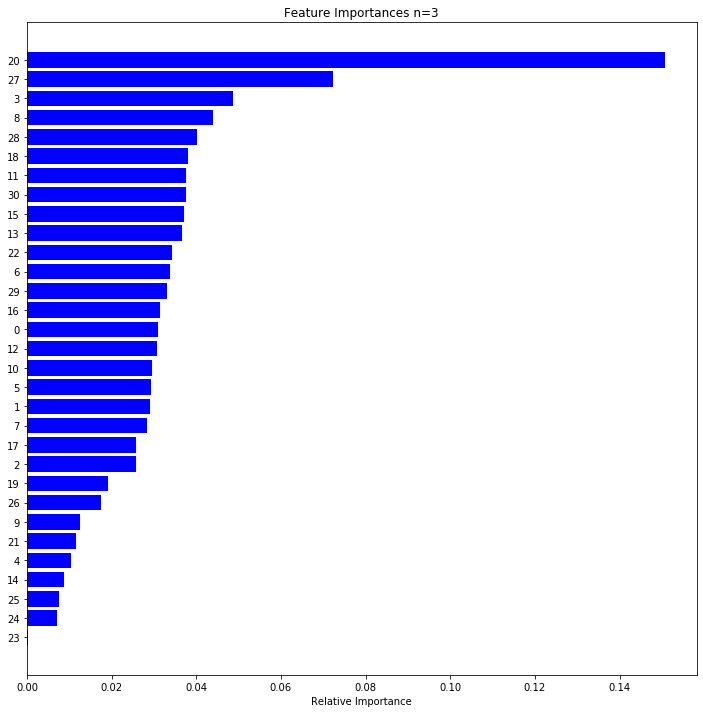

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline
importances = model3.feature_importances_
indices = np.argsort(importances)
feat_labels = x_train.columns
features = []
print(" Feature Importance (n=3) :")
for f in range(x_train.shape[1]):
#    print(indices[f])
    print("%2d)%-*s%f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))
    features.append(feat_labels[indices[f]])
plt.figure(figsize=(12,12))
plt.title('Feature Importances n=3')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),indices)
plt.xlabel('Relative Importance')
top10_3= features[-10:]

 Feature Importance (n=5) :
 1)SAR_crossover                 0.000471
 2)OBV_divergence                0.004981
 3)TEMA_crossover                0.006482
 4)EMA50-200                     0.009569
 5)ATR_close                     0.010367
 6)SMA50-200                     0.011342
 7)WMA50-200                     0.012056
 8)BB_squeeze                    0.012258
 9)DEMA50-200                    0.017972
10)SMA200                        0.025235
11)EMA200                        0.028114
12)EMA14                         0.028120
13)WMA200                        0.028751
14)WMA50                         0.029648
15)WMA14                         0.029673
16)DEMA200                       0.029705
17)EMA50                         0.031674
18)SMA50                         0.031977
19)SMA14                         0.033490
20)MACD_crossover_12_29_9        0.033962
21)DEMA50                        0.034807
22)CMO_crossover                 0.034998
23)DEMA14                        0.035298
24)EMA

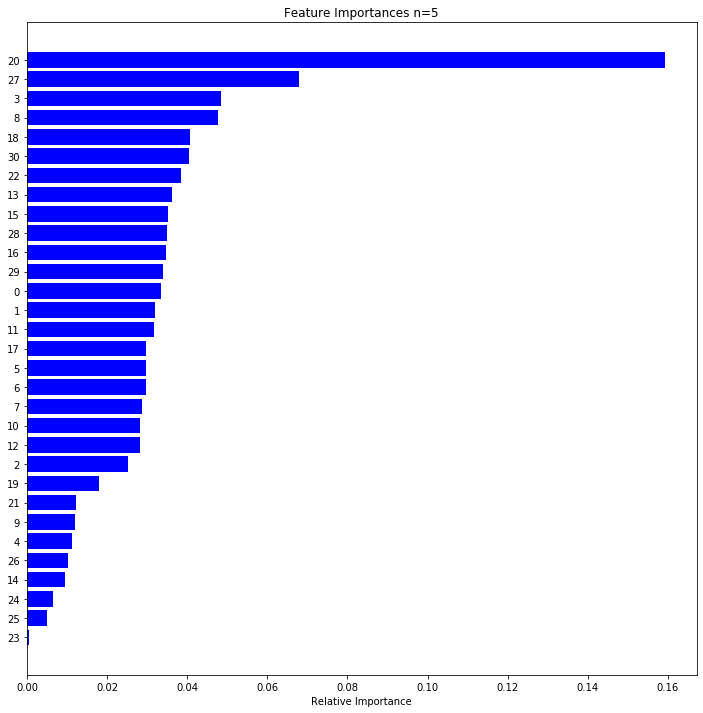

In [158]:
importances = model5.feature_importances_
indices = np.argsort(importances)
feat_labels = x_train.columns
features = []
print(" Feature Importance (n=5) :")
for f in range(x_train.shape[1]):
#    print(indices[f])
    print("%2d)%-*s%f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))
    features.append(feat_labels[indices[f]])
plt.figure(figsize=(12,12))
plt.title('Feature Importances n=5')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),indices)
plt.xlabel('Relative Importance')
top10_5= features[-10:]

 Feature Importance (n=10) :
 1)SAR_crossover                 0.000795
 2)OBV_divergence                0.002538
 3)TEMA_crossover                0.006698
 4)EMA50-200                     0.008779
 5)SMA50-200                     0.010381
 6)ATR_close                     0.012431
 7)BB_squeeze                    0.012901
 8)WMA50-200                     0.013966
 9)DEMA50-200                    0.017732
10)SMA200                        0.024746
11)EMA200                        0.026973
12)WMA200                        0.027787
13)EMA14                         0.028032
14)WMA14                         0.028139
15)WMA50                         0.029170
16)SMA50                         0.029858
17)EMA50                         0.030472
18)DEMA200                       0.030660
19)SMA14                         0.031636
20)DEMA50                        0.034054
21)CMO_crossover                 0.034264
22)EMA5-10                       0.035490
23)MACD_crossover_12_29_9        0.035606
24)MA

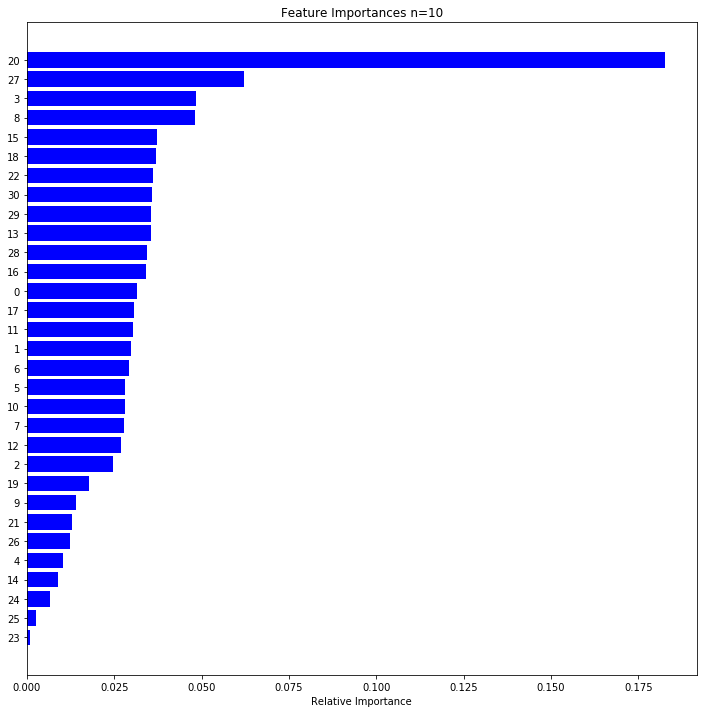

In [159]:
importances = model10.feature_importances_
indices = np.argsort(importances)
feat_labels = x_train.columns
features = []
print(" Feature Importance (n=10) :")
for f in range(x_train.shape[1]):
#    print(indices[f])
    print("%2d)%-*s%f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))
    features.append(feat_labels[indices[f]])
plt.figure(figsize=(12,12))
plt.title('Feature Importances n=10')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),indices)
plt.xlabel('Relative Importance')
top10_10= features[-10:]

### print out the top 10 simple rules of n-day returns

In [160]:
print("top 10 simple rules (n=3):", top10_3)
print("top 10 simple rules (n=5):", top10_5)
print("top 10 simple rules (n=10):", top10_10)

top 10 simple rules (n=3): ['EMA5-10', 'DEMA14', 'MACD_crossover_5_35_5', 'EMA50', 'DEMA5-10', 'CMO_crossover', 'WMA5-10', 'SMA5-10', 'HT_crossover', 'BB_crossover']
top 10 simple rules (n=5): ['CMO_crossover', 'DEMA14', 'EMA5-10', 'KAMA_crossover', 'MACD_crossover_5_35_5', 'DEMA5-10', 'WMA5-10', 'SMA5-10', 'HT_crossover', 'BB_crossover']
top 10 simple rules (n=10): ['EMA5-10', 'MACD_crossover_12_29_9', 'MACD_crossover_5_35_5', 'KAMA_crossover', 'DEMA5-10', 'DEMA14', 'WMA5-10', 'SMA5-10', 'HT_crossover', 'BB_crossover']


In [161]:
print('model3 accuracy: ', model3.score(x_test , y_test['signal3']))
print('model5 accuracy: ', model3.score(x_test , y_test['signal5']))
print('model10 accuracy: ', model3.score(x_test , y_test['signal10']))

model3 accuracy:  0.34118636312314665
model5 accuracy:  0.3370800872360782
model10 accuracy:  0.3378288437654134


In [162]:
from pandas_ml import ConfusionMatrix
y_pred3 = model3.predict(x_test)
y_pred5 = model5.predict(x_test)
y_pred10 = model10.predict(x_test)

labels = ['-1', '0', '1']

cfm3 = ConfusionMatrix(np.ravel(y_test['signal3']),y_pred3)
cfm5 = ConfusionMatrix(np.ravel(y_test['signal5']),y_pred5)
cfm10 = ConfusionMatrix(np.ravel(y_test['signal10']),y_pred10)

In [163]:
cfm3

Predicted     -1       0       1  __all__
Actual                                   
-1          4672   55198   51489   111359
0           4264   57302   50193   111759
1           4554   56031   52855   113440
__all__    13490  168531  154537   336558

In [164]:
cfm5

Predicted    -1      0       1  __all__
Actual                                 
-1         3241   9320   99329   111890
0          3115  10150   98409   111674
1          3323   9448  100223   112994
__all__    9679  28918  297961   336558

In [165]:
cfm10

Predicted     -1      0       1  __all__
Actual                                  
-1          6013   8993   96545   111551
0           5799   9950   96086   111835
1           6129   9164   97879   113172
__all__    17941  28107  290510   336558

## Construct complex rules

* 2-way Rules: combine two simple rules
* 3-way Rules: combine three simple rules
### Combining rules:
1. For combining multiple signals into a final buy/sell decision, we assign a
larger weight to trade signals (buy or sell) than to hold signals.
2. In case of multiple trade signals, we employ majority voting for deriving the
final outcome

In [166]:
columns3 = top10_3
columns5 = top10_5
columns10 = top10_10

### select the most important 20 3-way complex rules (n=3)

In [167]:
df.columns

Index(['Dates', 'PX_VOLUME', 'PX_LAST', 'PX_LOW', 'PX_HIGH', 'PX_OPEN',
       'SMA14', 'SMA50', 'SMA200', 'SMA5-10', 'SMA50-200', 'WMA14', 'WMA50',
       'WMA200', 'WMA5-10', 'WMA50-200', 'EMA14', 'EMA50', 'EMA200', 'EMA5-10',
       'EMA50-200', 'DEMA14', 'DEMA50', 'DEMA200', 'DEMA5-10', 'DEMA50-200',
       'BB_crossover', 'BB_squeeze', 'KAMA_crossover', 'SAR_crossover',
       'TEMA_crossover', 'OBV_divergence', 'ATR_close', 'HT_crossover',
       'CMO_crossover', 'MACD_crossover_12_29_9', 'MACD_crossover_5_35_5',
       'intraday_return', 'return3', 'return5', 'return10', 'signal3',
       'signal5', 'signal10'],
      dtype='object')

In [168]:
df3 = df.copy()
for x in ['Dates', 'PX_VOLUME', 'PX_LAST', 'PX_LOW', 'PX_HIGH', 'PX_OPEN','return5', 'return10','signal5', 'signal10','intraday_return']:
          del df3[x]
df3.head()

,SMA14,SMA50,SMA200,SMA5-10,SMA50-200,WMA14,WMA50,WMA200,WMA5-10,WMA50-200,...,SAR_crossover,TEMA_crossover,OBV_divergence,ATR_close,HT_crossover,CMO_crossover,MACD_crossover_12_29_9,MACD_crossover_5_35_5,return3,signal3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.003122,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.004202,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.001036,0
3,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.050989,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.045000,-1


In [169]:
# construct 3-way complex rules
# For combining multiple signals into a final buy/sell decision, we assign a larger weight to trade signals (buy or sell) than to hold signals.
# In case of multiple trade signals, we employ majority voting for deriving the final outcome
# When combining buy and sell signal, our decision is hold
columns = columns3
three_way_columns = []
for i in range(len(columns)-2):
    for j in range(i+1, len(columns)-1):
        for k in range(j+1, len(columns)):
            print(i,j,k)
            df3[columns[i] + '+' + columns[j] + '+' + columns[k]] = np.array([1 if x+y+z>0 else -1 if x+y+z<0 else 0 for (x, y, z) in zip(df3[columns[i]], df3[columns[j]], df3[columns[k]])]) 
            three_way_columns.append(columns[i] + '+' + columns[j] + '+' + columns[k])

0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 5 6
0 5 7
0 5 8
0 5 9
0 6 7
0 6 8
0 6 9
0 7 8
0 7 9
0 8 9
1 2 3
1 2 4
1 2 5
1 2 6
1 2 7
1 2 8
1 2 9
1 3 4
1 3 5
1 3 6
1 3 7
1 3 8
1 3 9
1 4 5
1 4 6
1 4 7
1 4 8
1 4 9
1 5 6
1 5 7
1 5 8
1 5 9
1 6 7
1 6 8
1 6 9
1 7 8
1 7 9
1 8 9
2 3 4
2 3 5
2 3 6
2 3 7
2 3 8
2 3 9
2 4 5
2 4 6
2 4 7
2 4 8
2 4 9
2 5 6
2 5 7
2 5 8
2 5 9
2 6 7
2 6 8
2 6 9
2 7 8
2 7 9
2 8 9
3 4 5
3 4 6
3 4 7
3 4 8
3 4 9
3 5 6
3 5 7
3 5 8
3 5 9
3 6 7
3 6 8
3 6 9
3 7 8
3 7 9
3 8 9
4 5 6
4 5 7
4 5 8
4 5 9
4 6 7
4 6 8
4 6 9
4 7 8
4 7 9
4 8 9
5 6 7
5 6 8
5 6 9
5 7 8
5 7 9
5 8 9
6 7 8
6 7 9
6 8 9
7 8 9


In [170]:
tr3 = df3.iloc[train.index,:]
te3 = df3.iloc[test.index,:]

In [171]:
tr3_x = tr3.iloc[:, 33:]
tr3_y = tr3.iloc[:, 32]

te3_x = te3.iloc[:, 33:]
te3_y = te3.iloc[:, 32]

 Feature Importance (n=3) :
 1)EMA5-10+EMA50+DEMA5-10        0.005474
 2)DEMA14+CMO_crossover+WMA5-10  0.005755
 3)EMA50+DEMA5-10+BB_crossover   0.005767
 4)EMA5-10+DEMA14+WMA5-10        0.006001
 5)EMA5-10+MACD_crossover_5_35_5+CMO_crossover0.006039
 6)CMO_crossover+SMA5-10+BB_crossover0.006139
 7)EMA5-10+DEMA14+MACD_crossover_5_35_50.006183
 8)EMA50+DEMA5-10+WMA5-10        0.006215
 9)EMA5-10+CMO_crossover+SMA5-10 0.006252
10)MACD_crossover_5_35_5+CMO_crossover+BB_crossover0.006300
11)EMA5-10+DEMA5-10+SMA5-10      0.006321
12)EMA5-10+DEMA14+CMO_crossover  0.006392
13)MACD_crossover_5_35_5+EMA50+BB_crossover0.006402
14)EMA5-10+DEMA14+EMA50          0.006449
15)EMA5-10+MACD_crossover_5_35_5+EMA500.006469
16)DEMA5-10+CMO_crossover+BB_crossover0.006573
17)DEMA14+MACD_crossover_5_35_5+EMA500.006661
18)MACD_crossover_5_35_5+SMA5-10+BB_crossover0.006682
19)MACD_crossover_5_35_5+DEMA5-10+CMO_crossover0.006723
20)EMA50+SMA5-10+BB_crossover    0.006759
21)DEMA5-10+WMA5-10+BB_crossover 0.006813

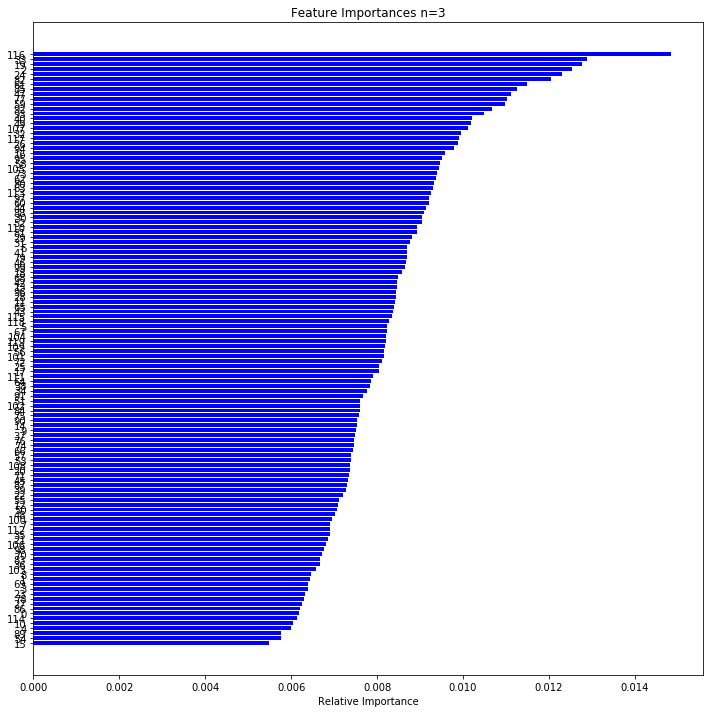

In [172]:
model3_three = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4)
model3_three.fit(tr3_x,np.ravel(tr3_y))

# select the 30 most important three-way rules 
import matplotlib.pyplot as plt
%matplotlib inline
importances = model3_three.feature_importances_
indices = np.argsort(importances)
feat_labels = tr3_x.columns
features = []
print(" Feature Importance (n=3) :")
for f in range(tr3_x.shape[1]):
#    print(indices[f])
    print("%2d)%-*s%f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))
    features.append(feat_labels[indices[f]])
plt.figure(figsize=(12,12))
plt.title('Feature Importances n=3')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),indices)
plt.xlabel('Relative Importance')

top20_3= features[-20:]

In [173]:
top20_3

['EMA50+WMA5-10+SMA5-10',
 'EMA5-10+CMO_crossover+WMA5-10',
 'WMA5-10+SMA5-10+BB_crossover',
 'EMA5-10+WMA5-10+BB_crossover',
 'DEMA5-10+SMA5-10+HT_crossover',
 'DEMA14+DEMA5-10+CMO_crossover',
 'DEMA14+MACD_crossover_5_35_5+SMA5-10',
 'EMA50+CMO_crossover+BB_crossover',
 'EMA50+CMO_crossover+HT_crossover',
 'DEMA14+WMA5-10+HT_crossover',
 'MACD_crossover_5_35_5+CMO_crossover+HT_crossover',
 'DEMA14+EMA50+HT_crossover',
 'EMA50+DEMA5-10+CMO_crossover',
 'DEMA14+SMA5-10+HT_crossover',
 'MACD_crossover_5_35_5+SMA5-10+HT_crossover',
 'EMA5-10+DEMA5-10+HT_crossover',
 'EMA5-10+DEMA14+DEMA5-10',
 'EMA5-10+EMA50+HT_crossover',
 'EMA5-10+SMA5-10+HT_crossover',
 'WMA5-10+SMA5-10+HT_crossover']

In [174]:
print('model3_three accuracy: ', model3_three.score(te3_x , te3_y))

model3_three accuracy:  0.3383369285531766


### select the most important 20 3-way complex rules (n=5)

 Feature Importance (n=5) :
 1)KAMA_crossover+DEMA5-10+WMA5-100.005181
 2)DEMA14+KAMA_crossover+BB_crossover0.005446
 3)CMO_crossover+DEMA14+WMA5-10  0.005699
 4)DEMA14+DEMA5-10+WMA5-10       0.005781
 5)DEMA14+EMA5-10+KAMA_crossover 0.005854
 6)DEMA14+WMA5-10+BB_crossover   0.005868
 7)MACD_crossover_5_35_5+DEMA5-10+WMA5-100.005899
 8)EMA5-10+MACD_crossover_5_35_5+BB_crossover0.005970
 9)CMO_crossover+EMA5-10+MACD_crossover_5_35_50.005977
10)DEMA5-10+WMA5-10+BB_crossover 0.006007
11)CMO_crossover+DEMA14+DEMA5-10 0.006112
12)DEMA14+KAMA_crossover+MACD_crossover_5_35_50.006141
13)EMA5-10+MACD_crossover_5_35_5+DEMA5-100.006195
14)CMO_crossover+MACD_crossover_5_35_5+SMA5-100.006203
15)CMO_crossover+DEMA14+EMA5-10  0.006329
16)DEMA14+DEMA5-10+BB_crossover  0.006332
17)CMO_crossover+MACD_crossover_5_35_5+WMA5-100.006355
18)DEMA14+MACD_crossover_5_35_5+SMA5-100.006356
19)EMA5-10+KAMA_crossover+DEMA5-100.006434
20)CMO_crossover+DEMA14+SMA5-10  0.006474
21)KAMA_crossover+MACD_crossover_5_35_5+

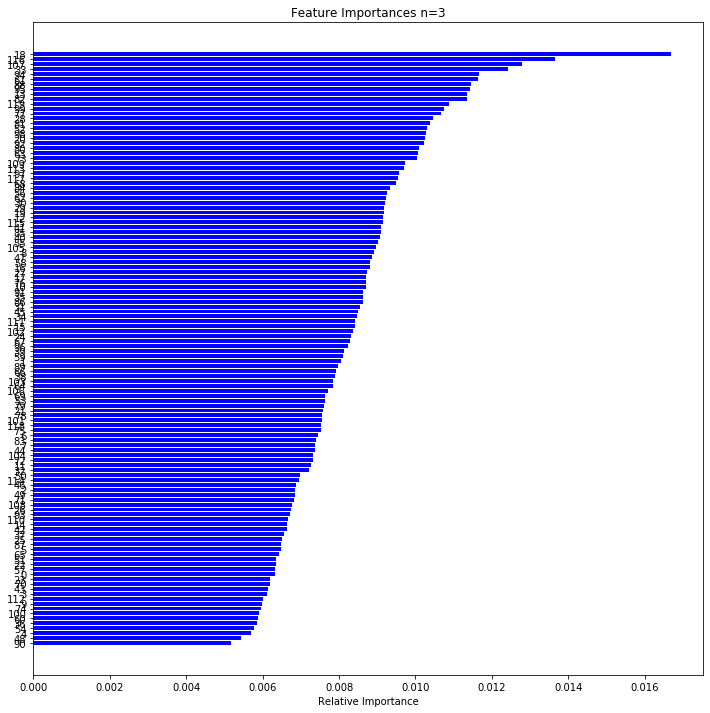

In [175]:
df5 = df.copy()
for x in ['Dates', 'PX_VOLUME', 'PX_LAST', 'PX_LOW', 'PX_HIGH', 'PX_OPEN','return3', 'return10','signal3', 'signal10','intraday_return']:
          del df5[x]

# construct 3-way complex rules
# For combining multiple signals into a final buy/sell decision, we assign a larger weight to trade signals (buy or sell) than to hold signals.
# In case of multiple trade signals, we employ majority voting for deriving the final outcome
# When combining buy and sell signal, our decision is hold
columns = columns5
three_way_columns = []
for i in range(len(columns)-2):
    for j in range(i+1, len(columns)-1):
        for k in range(j+1, len(columns)):
            df5[columns[i] + '+' + columns[j] + '+' + columns[k]] = np.array([1 if x+y+z>0 else -1 if x+y+z<0 else 0 for (x, y, z) in zip(df5[columns[i]], df5[columns[j]], df5[columns[k]])]) 
            three_way_columns.append(columns[i] + '+' + columns[j] + '+' + columns[k])

tr5 = df5.iloc[train.index,:]
te5 = df5.iloc[test.index,:]

tr5_x = tr5.iloc[:, 33:]
tr5_y = tr5.iloc[:, 32]

te5_x = te5.iloc[:, 33:]
te5_y = te5.iloc[:, 32]

model5_three = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4)
model5_three.fit(tr5_x,np.ravel(tr5_y))

# select the 30 most important three-way rules 
import matplotlib.pyplot as plt
%matplotlib inline
importances = model5_three.feature_importances_
indices = np.argsort(importances)
feat_labels = tr5_x.columns
features = []
print(" Feature Importance (n=5) :")
for f in range(tr5_x.shape[1]):
#    print(indices[f])
    print("%2d)%-*s%f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))
    features.append(feat_labels[indices[f]])
plt.figure(figsize=(12,12))
plt.title('Feature Importances n=3')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),indices)
plt.xlabel('Relative Importance')

top20_5= features[-20:]

In [176]:
print('model5_three accuracy: ', model5_three.score(te5_x , te5_y))

model5_three accuracy:  0.33818539449366825


### select the most important 20 3-way complex rules (n=10)

 Feature Importance (n=10) :
 1)EMA5-10+MACD_crossover_5_35_5+KAMA_crossover0.005295
 2)MACD_crossover_5_35_5+DEMA14+WMA5-100.005698
 3)EMA5-10+DEMA5-10+BB_crossover 0.005809
 4)EMA5-10+DEMA14+BB_crossover   0.005831
 5)EMA5-10+MACD_crossover_12_29_9+KAMA_crossover0.005870
 6)EMA5-10+MACD_crossover_5_35_5+BB_crossover0.005913
 7)EMA5-10+KAMA_crossover+DEMA14 0.005922
 8)MACD_crossover_5_35_5+DEMA5-10+SMA5-100.005992
 9)MACD_crossover_5_35_5+DEMA5-10+DEMA140.006131
10)MACD_crossover_5_35_5+KAMA_crossover+WMA5-100.006147
11)EMA5-10+KAMA_crossover+DEMA5-100.006230
12)MACD_crossover_5_35_5+WMA5-10+BB_crossover0.006345
13)MACD_crossover_12_29_9+DEMA14+WMA5-100.006368
14)DEMA14+WMA5-10+BB_crossover   0.006372
15)EMA5-10+MACD_crossover_12_29_9+BB_crossover0.006399
16)KAMA_crossover+DEMA14+HT_crossover0.006427
17)EMA5-10+MACD_crossover_12_29_9+MACD_crossover_5_35_50.006448
18)EMA5-10+MACD_crossover_5_35_5+DEMA140.006522
19)KAMA_crossover+DEMA14+BB_crossover0.006694
20)MACD_crossover_5_35_5+WMA

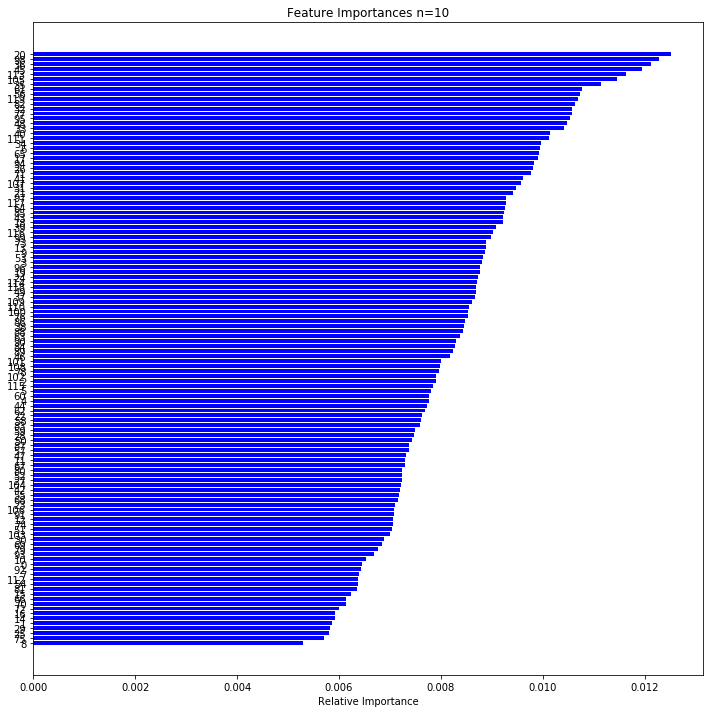

In [177]:
df10 = df.copy()
for x in ['Dates', 'PX_VOLUME', 'PX_LAST', 'PX_LOW', 'PX_HIGH', 'PX_OPEN','return3', 'return5','signal3', 'signal5','intraday_return']:
          del df10[x]

# construct 3-way complex rules
# For combining multiple signals into a final buy/sell decision, we assign a larger weight to trade signals (buy or sell) than to hold signals.
# In case of multiple trade signals, we employ majority voting for deriving the final outcome
# When combining buy and sell signal, our decision is hold
columns = columns10
three_way_columns = []
for i in range(len(columns)-2):
    for j in range(i+1, len(columns)-1):
        for k in range(j+1, len(columns)):
            df10[columns[i] + '+' + columns[j] + '+' + columns[k]] = np.array([1 if x+y+z>0 else -1 if x+y+z<0 else 0 for (x, y, z) in zip(df10[columns[i]], df10[columns[j]], df10[columns[k]])]) 
            three_way_columns.append(columns[i] + '+' + columns[j] + '+' + columns[k])

tr10 = df10.iloc[train.index,:]
te10 = df10.iloc[test.index,:]

tr10_x = tr10.iloc[:, 33:]
tr10_y = tr10.iloc[:, 32]

te10_x = te10.iloc[:, 33:]
te10_y = te10.iloc[:, 32]

model10_three = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4)
model10_three.fit(tr10_x,np.ravel(tr10_y))

# select the 30 most important three-way rules 
import matplotlib.pyplot as plt
%matplotlib inline
importances = model10_three.feature_importances_
indices = np.argsort(importances)
feat_labels = tr10_x.columns
features = []
print(" Feature Importance (n=10) :")
for f in range(tr10_x.shape[1]):
#    print(indices[f])
    print("%2d)%-*s%f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))
    features.append(feat_labels[indices[f]])
plt.figure(figsize=(12,12))
plt.title('Feature Importances n=10')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),indices)
plt.xlabel('Relative Importance')

top20_10= features[-20:]

In [178]:
print('model10_three accuracy: ', model10_three.score(te10_x , te10_y))

model10_three accuracy:  0.33671462273961694


### Print out the most important 20 3-way rules

In [179]:
print("the 20 most important 3-way rules:")
print('\n')
print('n=3: ', top20_3)
print('\n')
print('n=5: ', top20_5)
print('\n')
print('n=10: ', top20_10)

the 20 most important 3-way rules:


n=3:  ['EMA50+WMA5-10+SMA5-10', 'EMA5-10+CMO_crossover+WMA5-10', 'WMA5-10+SMA5-10+BB_crossover', 'EMA5-10+WMA5-10+BB_crossover', 'DEMA5-10+SMA5-10+HT_crossover', 'DEMA14+DEMA5-10+CMO_crossover', 'DEMA14+MACD_crossover_5_35_5+SMA5-10', 'EMA50+CMO_crossover+BB_crossover', 'EMA50+CMO_crossover+HT_crossover', 'DEMA14+WMA5-10+HT_crossover', 'MACD_crossover_5_35_5+CMO_crossover+HT_crossover', 'DEMA14+EMA50+HT_crossover', 'EMA50+DEMA5-10+CMO_crossover', 'DEMA14+SMA5-10+HT_crossover', 'MACD_crossover_5_35_5+SMA5-10+HT_crossover', 'EMA5-10+DEMA5-10+HT_crossover', 'EMA5-10+DEMA14+DEMA5-10', 'EMA5-10+EMA50+HT_crossover', 'EMA5-10+SMA5-10+HT_crossover', 'WMA5-10+SMA5-10+HT_crossover']


n=5:  ['EMA5-10+WMA5-10+HT_crossover', 'KAMA_crossover+DEMA5-10+HT_crossover', 'CMO_crossover+KAMA_crossover+BB_crossover', 'KAMA_crossover+SMA5-10+BB_crossover', 'DEMA14+MACD_crossover_5_35_5+HT_crossover', 'EMA5-10+WMA5-10+BB_crossover', 'CMO_crossover+DEMA5-10+HT_crossover', 

In [180]:
print('model3_three accuracy: ', model3_three.score(te3_x , te3_y))
print('model5_three accuracy: ', model5_three.score(te5_x , te5_y))
print('model10_three accuracy: ', model10_three.score(te10_x , te10_y))

model3_three accuracy:  0.3383369285531766
model5_three accuracy:  0.33818539449366825
model10_three accuracy:  0.33671462273961694


## Using the most important 3-way rules to train new models

In [181]:
from sklearn.ensemble import RandomForestClassifier

model3_top20 = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4)
model5_top20 = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4)
model10_top20 = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4)

In [182]:
tr3_x_top20 = tr3_x[top20_3]
te3_x_top20 = te3_x[top20_3]

tr3_y_top20 = tr3_y
te3_y_top20 = te3_y

model3_top20.fit(tr3_x_top20,np.ravel(tr3_y_top20))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [183]:
tr5_x_top20 = tr5_x[top20_5]
te5_x_top20 = te5_x[top20_5]

tr5_y_top20 = tr5_y
te5_y_top20 = te5_y

model5_top20.fit(tr5_x_top20,np.ravel(tr5_y_top20))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [184]:
tr10_x_top20 = tr10_x[top20_10]
te10_x_top20 = te10_x[top20_10]

tr10_y_top20 = tr10_y
te10_y_top20 = te10_y

model10_top20.fit(tr10_x_top20,np.ravel(tr10_y_top20))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

<h3>Accuracy</h3>

In [185]:
print('model3_top20 accuracy: ', model3_top20.score(te3_x_top20, te3_y_top20 ))
print('model5_top20 accuracy: ', model5_top20.score(te5_x_top20, te5_y_top20 ))
print('model10_top20 accuracy: ', model10_top20.score(te10_x_top20, te10_y_top20 ))

model3_top20 accuracy:  0.3375109193660528
model5_top20 accuracy:  0.33802197540988477
model10_top20 accuracy:  0.33714842612566037


### Comfusion Matrix

In [186]:
from pandas_ml import ConfusionMatrix
y_pred3_top20 = model3_top20.predict(te3_x_top20)
y_pred5_top20 = model5_top20.predict(te5_x_top20)
y_pred10_top20 = model10_top20.predict(te10_x_top20)

cfm3 = ConfusionMatrix(np.ravel(te3_y_top20),y_pred3_top20)
cfm5 = ConfusionMatrix(np.ravel(te5_y_top20),y_pred5_top20)
cfm10 = ConfusionMatrix(np.ravel(te10_y_top20),y_pred10_top20)

In [187]:
cfm3

Predicted     -1       0       1  __all__
Actual                                   
-1         18063   54509   38787   111359
0          17216   55655   38888   111759
1          18094   55472   39874   113440
__all__    53373  165636  117549   336558

In [188]:
cfm5

Predicted     -1      0       1  __all__
Actual                                  
-1         14705  19389   77796   111890
0          14310  20084   77280   111674
1          14714  19305   78975   112994
__all__    43729  58778  234051   336558

In [189]:
cfm10

Predicted     -1      0       1  __all__
Actual                                  
-1         18858  12011   80682   111551
0          18778  12706   80351   111835
1          19249  12017   81906   113172
__all__    56885  36734  242939   336558

## Comparison between models

In [191]:
## the accuracy of models using only the 31 simple rules
acc3 = model3.score(x_test , y_test['signal3'])
acc5 = model5.score(x_test , y_test['signal5'])
acc10 = model10.score(x_test , y_test['signal10'])

## the accuracy of models using all the 120 3-way complex rules combined by top 10 simple rules (10*9*8/3*2 = 120)
acc3_three = model3_three.score(te3_x , te3_y)
acc5_three = model5_three.score(te5_x , te5_y)
acc10_three = model10_three.score(te10_x , te10_y)

## the accuracy of models using only the top 20 3-way complex rules
acc3_top20 = model3_top20.score(te3_x_top20, te3_y_top20 )
acc5_top20 = model5_top20.score(te5_x_top20, te5_y_top20 )
acc10_top20 = model10_top20.score(te10_x_top20, te10_y_top20 )

In [225]:
%matplotlib inline
from matplotlib import pyplot as plt

col_labels = ['3-day','5-day','10-day']
row_labels = ['31 simple rules','120 3-way rules','top 20 3-way rules']
table_vals = pd.DataFrame([[acc3, acc5, acc10],[acc3_three, acc5_three, acc10_three ],[acc3_top20, acc5_top20, acc10_top20]])
table_vals.columns = col_labels
table_vals.index = row_labels
print("Comparison between different models:")
print(table_vals)

Comparison between different models:
                       3-day     5-day    10-day
31 simple rules     0.341186  0.337576  0.338254
120 3-way rules     0.338337  0.338185  0.336715
top 20 3-way rules  0.337511  0.338022  0.337148


<h2>Finding the best ensemble</h2>
<li>Using a gridsearch, we can run the random forest classifier on various parameter combinations
<li>And then use the classifier with the best accuracy score

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'n_estimators':(10, 30, 50), #the number of trees
     'max_depth':(4, 8, 10, 15),   # 15 can cause overfitting
     'min_samples_split': (2, 4, 8, 10, 16),   
     'min_samples_leaf': (4, 8, 12, 16)
}

model = GridSearchCV(RandomForestClassifier(),parameters,cv=3,iid=False)
model.fit(x_train, np.ravel(y_train))
model.best_score_, model.best_params_